In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import json
import seaborn as sns

import math
import re
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import pytz
from datetime import datetime
import time

import collections
from wordcloud import WordCloud

In [2]:
import settings
import mysql.connector
import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly
import random
import plotly.express as px
from IPython.display import clear_output
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
py.init_notebook_mode()

In [3]:
# Filter constants for states in US
STATES = ['Alabama', 'AL', 'Alaska', 'AK', 'American Samoa', 'AS', 'Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO', 'Connecticut', 'CT', 'Delaware', 'DE', 'District of Columbia', 'DC', 'Federated States of Micronesia', 'FM', 'Florida', 'FL', 'Georgia', 'GA', 'Guam', 'GU', 'Hawaii', 'HI', 'Idaho', 'ID', 'Illinois', 'IL', 'Indiana', 'IN', 'Iowa', 'IA', 'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', 'Maine', 'ME', 'Marshall Islands', 'MH', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', 'Minnesota', 'MN', 'Mississippi', 'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', 'Nevada', 'NV', 'New Hampshire', 'NH', 'New Jersey', 'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Northern Mariana Islands', 'MP', 'Ohio', 'OH', 'Oklahoma', 'OK', 'Oregon', 'OR', 'Palau', 'PW', 'Pennsylvania', 'PA', 'Puerto Rico', 'PR', 'Rhode Island', 'RI', 'South Carolina', 'SC', 'South Dakota', 'SD', 'Tennessee', 'TN', 'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT', 'Virgin Islands', 'VI', 'Virginia', 'VA', 'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', 'Wyoming', 'WY']
STATE_DICT = dict(itertools.zip_longest(*[iter(STATES)] * 2, fillvalue=""))
INV_STATE_DICT = dict((v,k) for k,v in STATE_DICT.items())

In [4]:
# Read json data containing tweets
tweets_data_path = 'elite.json'

with open(tweets_data_path) as f:
  tweets_data = json.load(f)


In [5]:
print("The total number of Tweets is:",len(tweets_data))
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(tweets_data[0])

The total number of Tweets is: 1450
{   'coordinates': None,
    'created_at': '2020-03-16 23:30:20.000000',
    'favorites_count': 0,
    'geo': None,
    'id': 35,
    'id_str': '1239695526045650949',
    'in_reply_to': None,
    'polarity': 0.17045454545454544,
    'retweet_count': 0,
    'subjectivity': 0.45454545454545453,
    'text': 'RT @realmmarshall1: All new Road To!  We’ll see everyone this '
            'Wednesday night on @AEWonTNT for #AEWDynamite '
            'https://t.co/3BxyejQOpQ',
    'user_created': '2012-07-03 06:29:42.000000',
    'user_description': '35 big pro wrestling fan; AEW Wrestling rules; fan of '
                        'the Joker all things comic book nerd, pro wrestling '
                        "fandom oh and ROLL TIDE...bitches...mic drop...I'm "
                        'OUT',
    'user_followers_count': 169,
    'user_friends_count': 772,
    'user_location': 'Amherst NY',
    'user_name': 'EricBuffalo316'}


In [6]:
# Convert json to dataframe
tweets_df = pd.read_json(tweets_data_path, orient='columns')

In [7]:
#tweets_df.head()
tweets_df['in_reply_to'] = tweets_df['in_reply_to'].apply(lambda i : i or '')

In [8]:
# clean the text, remove \n and special characters and emojis
tweets_df['text'] = tweets_df['text'].apply(lambda text: re.sub(r"\n", " ", text))
tweets_df['text'] = tweets_df['text'].apply(lambda text: text.encode('ascii', 'ignore').decode('ascii'))

In [9]:
# add column is_retweet
tweets_df['is_retweet'] = tweets_df['text'].apply(lambda x: False if 'RT' not in x else True)

In [10]:
# convert created_at and user_created time to CST
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format = '%Y-%m-%d %H:%M:%S')
tweets_df['created_at'] = tweets_df['created_at'].dt.tz_localize('utc')
tweets_df['created_at'] = tweets_df['created_at'].dt.tz_convert('US/Central')
tweets_df['user_created'] = pd.to_datetime(tweets_df['user_created'], format = '%Y-%m-%d %H:%M:%S')
tweets_df['user_created'] = tweets_df['user_created'].dt.tz_localize('utc')
tweets_df['user_created'] = tweets_df['user_created'].dt.tz_convert('US/Central')
tweets_df.head()

id                created_at               id_str  \
0  35 2020-03-16 18:30:20-05:00  1239695526045650944   
1  36 2020-03-16 18:30:34-05:00  1239695585143164928   
2  37 2020-03-16 18:30:41-05:00  1239695613232656384   
3  38 2020-03-16 18:30:43-05:00  1239695621583523840   
4  39 2020-03-16 18:30:44-05:00  1239695627719770112   

                                                text   in_reply_to  \
0  RT @realmmarshall1: All new Road To!  Well see...                 
1  @SportsCenter @WWE Bruh these days it can be 2...  SportsCenter   
2  RT @CodyRhodes: Brand new #aew Road To... toni...                 
3  RT @sammyguevara:  you got a friend in me, you...                 
4  RT @AEWrestling: Can the #BestFriends gain the...                 

        user_name       user_location  \
0  EricBuffalo316          Amherst NY   
1   TheRealRalphC                None   
2    Jayystackks1       New York, USA   
3  Wwe_queenbeast          Texas, USA   
4  EricMoreno6477  San Antonio, Texas   

                                    user_description  \
0  35 big pro wrestling fan; AEW Wrestling rules;...   
1                                       MambaForever   
2  MEDIA BlOG for for ProWrestling.@wwenxt. @AEWr...   
3              I’m a hardcore wwe fan and love anime   
4  I read, I write, I travel – I live my life the...   

               user_created   geo coordinates  user_followers_count  \
0 2012-07-03 01:29:42-05:00  None        None                   169   
1 2012-03-11 21:09:35-05:00  None        None                    71   
2 2018-08-13 16:02:43-05:00  None        None                    78   
3 2019-10-27 19:52:22-05:00  None        None                    47   
4 2010-03-11 10:45:15-06:00  None        None                  1003   

   user_friends_count  retweet_count  favorites_count  polarity  subjectivity  \
0                 772              0                0  0.170455      0.454545   
1                  58              0                0  0.000000      0.000000   
2                 470              0                0  0.170455      0.454545   
3                 348              0                0  0.625000      0.500000   
4                4373              0                0  0.000000      0.000000   

   is_retweet  
0        True  
1       False  
2        True  
3        True  
4        True

In [11]:
# Compute # of RT's, @'s, and text tweets
retweet_tweets = tweets_df[tweets_df['is_retweet'] == True]
response_tweets = tweets_df[tweets_df['in_reply_to']!='']
mention_tweets = tweets_df[~tweets_df['text'].str.contains("RT")  & tweets_df['text'].str.contains("@")]
mention_tweets = mention_tweets[mention_tweets['in_reply_to']==""]
text_tweets = tweets_df[~tweets_df['text'].str.contains("@")  & ~tweets_df['text'].str.contains("RT")]
url_tweets = tweets_df[tweets_df['text'].str.contains("http")]

print("Total number of tweets:", len(tweets_df))
print("Total number of retweets:", len(retweet_tweets))
print("Total number of response tweets:", len(response_tweets))
print("Total number of tweets with mentions that are not retweets or responses:", len(mention_tweets))
print("Total number of text tweets:", len(text_tweets))
print("Number of tweets containing URL links:", len(url_tweets))
print("Number of different users:", tweets_df['user_name'].nunique())
print("Number of tweets per user:", len(tweets_df)/tweets_df['user_name'].nunique())

Total number of tweets: 1450
Total number of retweets: 1048
Total number of response tweets: 83
Total number of tweets with mentions that are not retweets or responses: 80
Total number of text tweets: 243
Number of tweets containing URL links: 427
Number of different users: 1054
Number of tweets per user: 1.3757115749525617


In [12]:
values = [ len(retweet_tweets), len(response_tweets), len(mention_tweets), len(text_tweets)]
labels = ['Retweets', 'Responses', 'Mentions', 'Text tweets']
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title_text = 'Percentage of Tweets by Type'
)
fig.show()

In [13]:
# Find most used hashtags
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(tweets_df['text'].apply(hashtag_pattern.findall))
hashtag_words = []
for match in hashtag_matches:
    for word in match:
        hashtag_words.append(word.lower())

In [14]:
# hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1])
# hashtag_ordered_list = hashtag_ordered_list[::-1]
# hashtag_ordered_values = []
# hashtag_ordered_keys = []
# for item in hashtag_ordered_list[0:50]:
#     hashtag_ordered_keys.append(item[0])
#     hashtag_ordered_values.append(item[1])

In [15]:
# fig, ax = plt.subplots(figsize = (12,12))
# y_pos = np.arange(len(hashtag_ordered_keys))
# ax.barh(y_pos ,list(hashtag_ordered_values)[::-1], align='center', color = 'green', edgecolor = 'black', linewidth=1)
# ax.set_yticks(y_pos)
# ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
# ax.set_xlabel("Nº of appereances")
# ax.set_title("Most used #hashtags", fontsize = 20)
# plt.tight_layout(pad=3)
# plt.show()
fdist = FreqDist(hashtag_words)
fd = pd.DataFrame(fdist.most_common(50), columns = ["Word","Frequency"]).reindex()
trace = go.Bar(x=fd["Word"], y=fd["Frequency"], name="Freq Dist")
# data = [trace]
# py.iplot(data)
fig = go.Figure(trace)
fig.update_layout(
    title="Most Frequently Used Hashtags",
    xaxis_title="Hashtags",
    yaxis_title="Frequency",
)
fig.show()

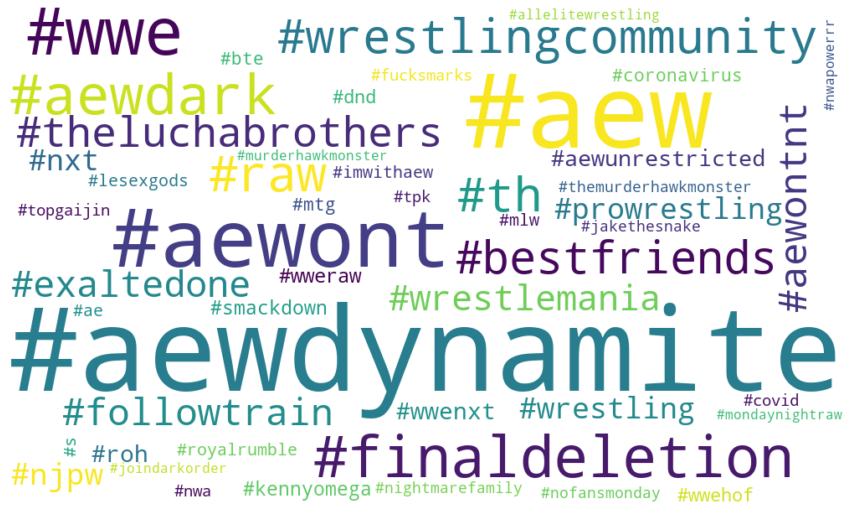

In [16]:
#Make a wordcloud plot of the most used hashtags
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [17]:
# Find most mentioned accounts
mentions = []
mention_pattern = re.compile(r"@[a-zA-Z_]+")
mention_matches = list(tweets_df['text'].apply(mention_pattern.findall))
mentioned_accounts = []
for match in mention_matches:
    for word in match:
        mentioned_accounts.append(word.lower())

In [18]:
fdist = FreqDist(mentioned_accounts)
fd = pd.DataFrame(fdist.most_common(50), columns = ["Word","Frequency"])
trace = go.Bar(x=fd["Word"], y=fd["Frequency"], name="Freq Dist")
# data = [trace]
# py.iplot(data)
fig = go.Figure(trace)
fig.update_layout(
    title="Most Mentioned Accounts",
    xaxis_title="Username",
    yaxis_title="Frequency",
)
fig.show()

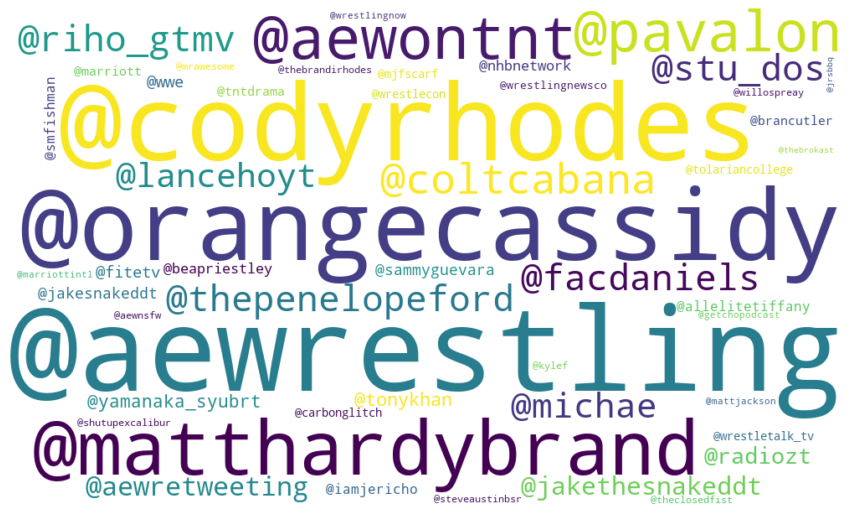

In [19]:
#Make a wordcloud representation
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [20]:
words = []
words_filtered = []
words = ' '.join(tweets_df["text"])
words = re.sub(r"http\S+", "", words)
words = words.replace('RT ', ' ').replace('&amp;', 'and')
words = re.sub('[^A-Za-z0-9]+', ' ', words)
words = words.lower()
tokenized_words = word_tokenize(words)
stopword_list=set(stopwords.words("english"))
#stopword_list.add("")
for word in tokenized_words:
    if word not in stopword_list:
        if "@"+word not in mentioned_accounts:#exclude accounts
            if "#"+word not in hashtag_words:#exclude hashtags
                words_filtered.append(word)


In [21]:
fdist = FreqDist(words_filtered)
fd = pd.DataFrame(fdist.most_common(50), columns = ["Word","Frequency"])#.drop([0]).reindex()
trace = go.Bar(x=fd["Word"], y=fd["Frequency"], name="Freq Dist")
# data = [trace]
# py.iplot(data)
fig = go.Figure(trace)
fig.update_layout(
    title="Most Frequently Words (excluding hashtags and usernames)",
    xaxis_title="Words",
    yaxis_title="Frequency",
)
fig.show()

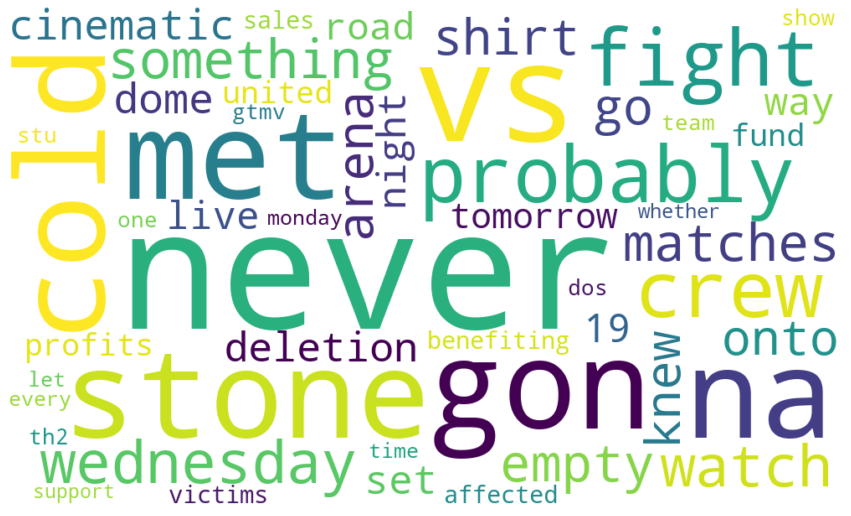

In [22]:
#Make a wordcloud representation
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [23]:
is_in_US=[]
geo = tweets_df[['user_location']]
tweets_df = tweets_df.fillna(" ")
for x in tweets_df['user_location']:
    check = False
    for s in STATES:
        if s in x:
            is_in_US.append(STATE_DICT[s] if s in STATE_DICT else s)
            check = True
            break
    if not check:
        is_in_US.append(None)
is_in_US
geo_dist = pd.DataFrame(is_in_US, columns=['State']).dropna().reset_index()
geo_dist = geo_dist.groupby('State').count().rename(columns={"index": "Number"}) \
        .sort_values(by=['Number'], ascending=False).reset_index()
geo_dist["Log Num"] = geo_dist["Number"].apply(lambda x: math.log(x, 2))
geo_dist['Full State Name'] = geo_dist['State'].apply(lambda x: INV_STATE_DICT[x])
geo_dist['text'] = geo_dist['Full State Name'] + '<br>' + 'Num: ' + geo_dist['Number'].astype(str)

fig = go.Figure(data=go.Choropleth(
    locations=geo_dist['State'], # Spatial coordinates
    z = geo_dist['Number'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Number of tweets",
))
fig.update_layout(
    title_text = 'Tweets by User Location',
    geo_scope='usa', # limite map scope to USA
)
fig.show()

In [50]:
# Time series
total = tweets_df.groupby(pd.Grouper(key='created_at', freq='60s')).count().reset_index()
total = total.rename(columns={"user_name": "Num of tweets", "created_at":"Time in CST"})  
time_series = total["Time in CST"].reset_index(drop=True)
result = tweets_df.groupby([pd.Grouper(key='created_at', freq='60s'), 'polarity']).count().reset_index()
result = result.rename(columns={"user_name": "Num of tweets", "created_at":"Time in CST"})  
time_series = result["Time in CST"][result['polarity']==0].reset_index(drop=True)

In [51]:
time_series

0     2020-03-16 18:30:00-05:00
1     2020-03-16 18:31:00-05:00
2     2020-03-16 18:32:00-05:00
3     2020-03-16 18:33:00-05:00
4     2020-03-16 18:34:00-05:00
                 ...           
246   2020-03-16 23:46:00-05:00
247   2020-03-16 23:47:00-05:00
248   2020-03-16 23:50:00-05:00
249   2020-03-16 23:51:00-05:00
250   2020-03-16 23:53:00-05:00
Name: Time in CST, Length: 251, dtype: datetime64[ns, US/Central]

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=time_series,
    y=total["Num of tweets"],
    name="Total",
    opacity=0.8))
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of tweets"][result['polarity']==0].reset_index(drop=True),
    name="Neural",
    opacity=0.8))
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of tweets"][result['polarity']>0].reset_index(drop=True),
    name="Negative",
    opacity=0.8))
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of tweets"][result['polarity']<0].reset_index(drop=True),
    name="Positive",
    opacity=0.8))

fig.update_layout(
    title="Number of Tweets over time (and sentiment of Tweets)",
    xaxis_title="Time in CST",
    yaxis_title="Frequency",
)
fig.show()


In [31]:
print("There are {} different users".format(tweets_df['user_name'].nunique()))

There are 1054 different users


In [32]:
user_tweets = tweets_df.groupby('user_name').count()
user_tweets = user_tweets.rename(columns={"text":"count"}).reset_index()
user_tweets.head()

user_name  id  created_at  id_str  count  in_reply_to  user_location  \
0    1984_Huxley   4           4       4      4            4              4   
1   19Phranchize   1           1       1      1            1              1   
2   215Wrestling   1           1       1      1            1              1   
3  23_Revelation   3           3       3      3            3              3   
4       3000Dojo   1           1       1      1            1              1   

   user_description  user_created  geo  coordinates  user_followers_count  \
0                 4             4    4            4                     4   
1                 1             1    1            1                     1   
2                 1             1    1            1                     1   
3                 3             3    3            3                     3   
4                 1             1    1            1                     1   

   user_friends_count  retweet_count  favorites_count  polarity  subjectivity  \
0                   4              4                4         4             4   
1                   1              1                1         1             1   
2                   1              1                1         1             1   
3                   3              3                3         3             3   
4                   1              1                1         1             1   

   is_retweet  
0           4  
1           1  
2           1  
3           3  
4           1

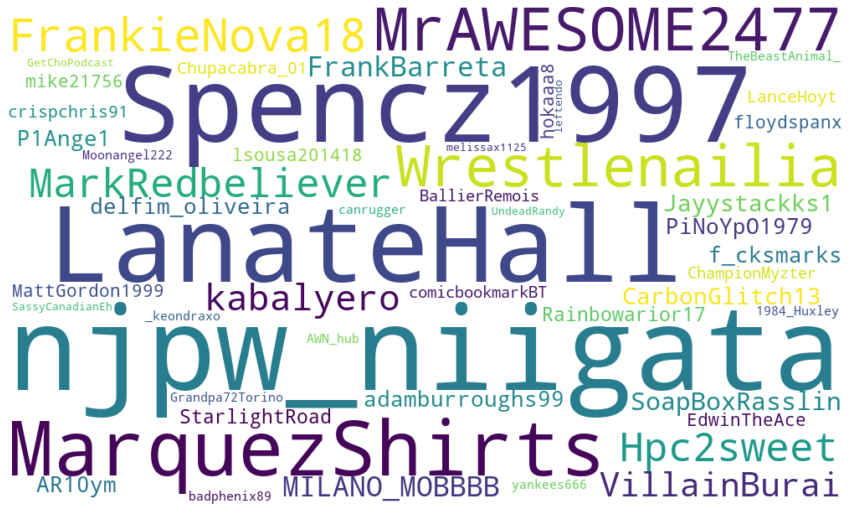

In [33]:
# Top 50 users with most tweets
fd = user_tweets[["user_name","count"]].sort_values(by=['count'], ascending=False).head(50)
# trace = go.Bar(x=fd["user_name"], y=fd["count"], name="Freq Dist")
# data = [trace]
# py.iplot(data)
#Make a wordcloud representation
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()